# Human Action Detection

## Data Preprocessing

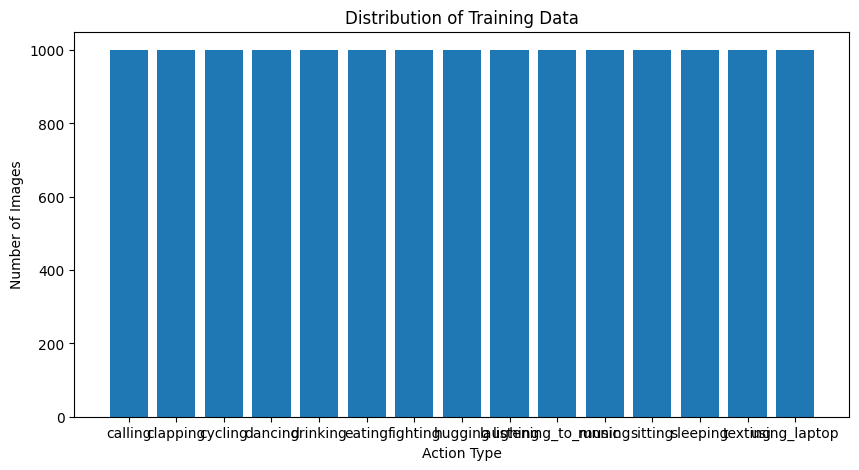

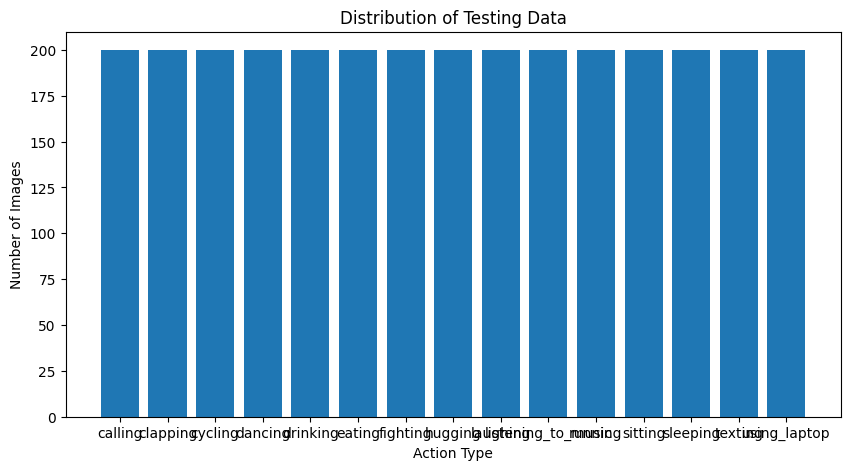

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter

path = 'emirhan_human_dataset/datasets/human_data'
train_data_path = path + '/train_data'
test_data = path + '/test_data'

def analyze_dataset(path, title):
    # get the list of all the files in the subfolders
    data_files = os.listdir(path)
    categories = []
    for file in data_files: 
        if os.path.isdir(path + '/' + file):
            categories.append(file)

    # then I want to get a count of the number of files in each of the subfolders
    action_type_counts = {}
    for action in categories:
        action_type_counts[action] = len(os.listdir(path + '/' + action))

    plt.figure(figsize=(10, 5))
    plt.bar(action_type_counts.keys(), action_type_counts.values())
    plt.xlabel('Action Type')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.show()

analyze_dataset(train_data_path, title="Distribution of Training Data") 
analyze_dataset(test_data, "Distribution of Testing Data")

## Model

In [20]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

# Data preparation using ImageDataGenerator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "emirhan_human_dataset/datasets/human_data/train_data",
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    "emirhan_human_dataset/datasets/human_data/test_data",
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical',
    shuffle = False)

base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='avg')
base_model.trainable = False  # Freeze the base model to not train it
inputs = base_model.input
x = Dense(64, activation='relu')(base_model.output)
x = Dense(64, activation='relu')(x)
outputs = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1)]
model.fit(train_generator, validation_data=test_generator, epochs=5, callbacks=callbacks, verbose=1)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Epoch 1/5


c:\Users\zhxu3\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.3323 - loss: 2.0899 - val_accuracy: 0.5733 - val_loss: 1.3202
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 24s 200ms/step - accuracy: 0.6515 - loss: 1.1078 - val_accuracy: 0.6053 - val_loss: 1.2163
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step - accuracy: 0.6910 - loss: 0.9616 - val_accuracy: 0.6243 - val_loss: 1.1474
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 24s 201ms/step - accuracy: 0.7201 - loss: 0.8681 - val_accuracy: 0.6267 - val_loss: 1.1436
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 25s 207ms/step - accuracy: 0.7428 - loss: 0.7840 - val_accuracy: 0.6377 - val_loss: 1.1061


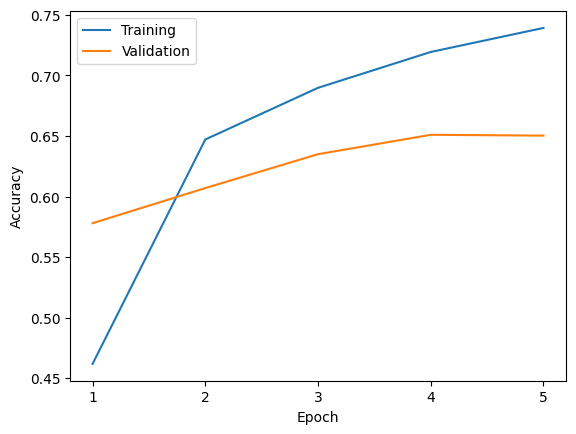

In [18]:
# Evaluate training and validation accuracy
history = model.history.history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
epochs = len(history['accuracy'])
plt.xticks(range(epochs), [str(i+1) for i in range(epochs)])
plt.legend(['Training', 'Validation'])
plt.show()

In [23]:
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

test_accuracy = np.mean(predicted_classes == true_classes)
print(f"Test Accuracy: {test_accuracy:.2f}")

class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step
Test Accuracy: 0.64
Classification Report:
                     precision    recall  f1-score   support

           calling       0.46      0.45      0.45       200
          clapping       0.57      0.56      0.56       200
           cycling       0.90      0.95      0.93       200
           dancing       0.72      0.69      0.71       200
          drinking       0.63      0.58      0.60       200
            eating       0.73      0.80      0.76       200
          fighting       0.69      0.79      0.73       200
           hugging       0.66      0.66      0.66       200
          laughing       0.64      0.64      0.64       200
listening_to_music       0.45      0.44      0.45       200
           running       0.86      0.71      0.78       200
           sitting       0.46      0.60      0.52       200
          sleeping       0.68      0.65      0.66       200
           texting       0.55      0.44      0.49       200
      using_la

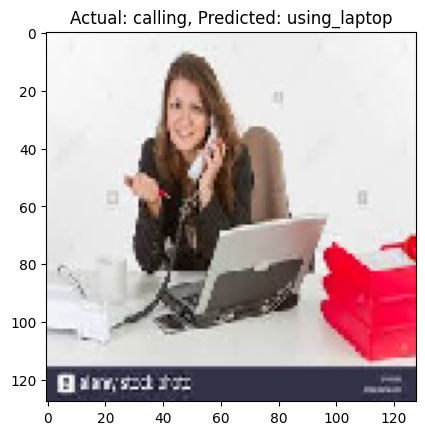

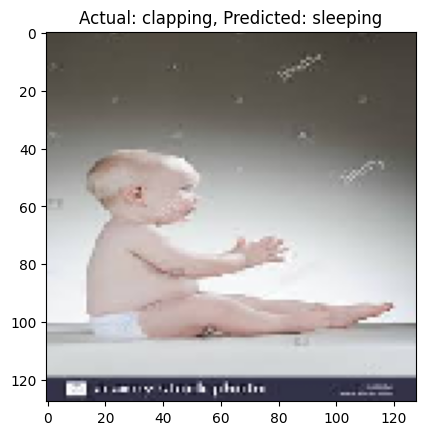

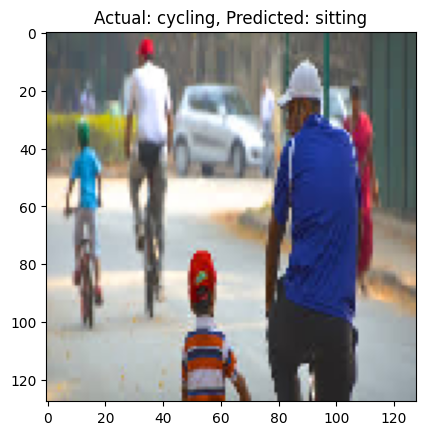

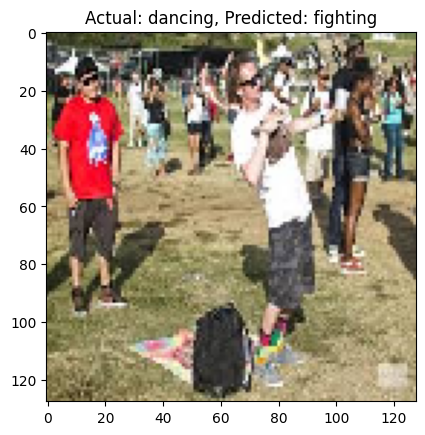

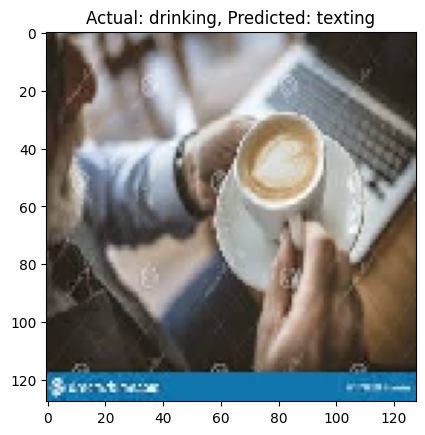

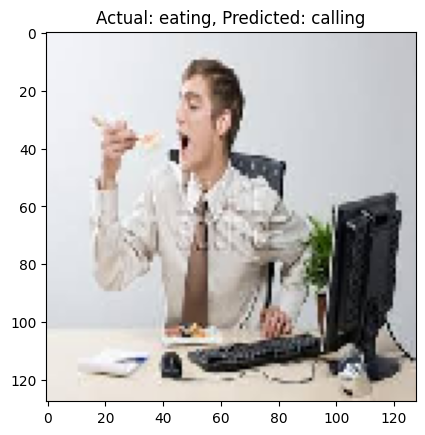

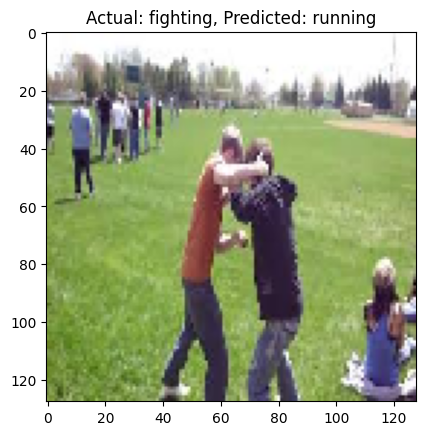

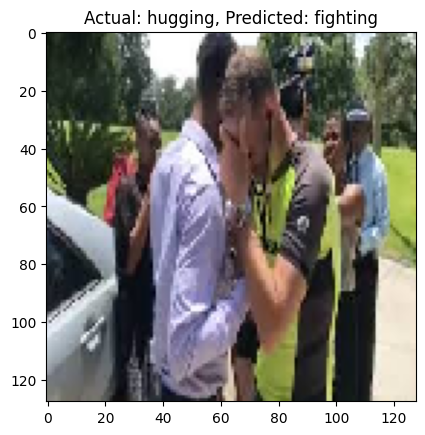

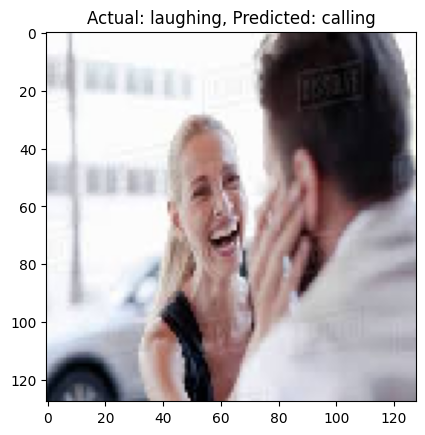

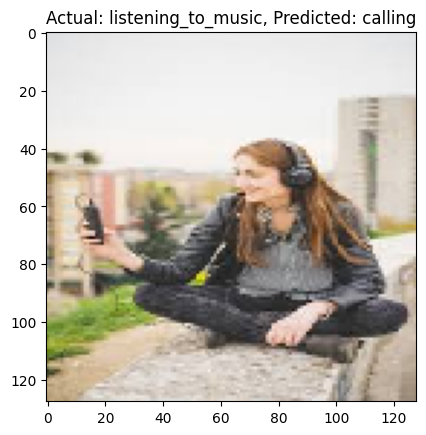

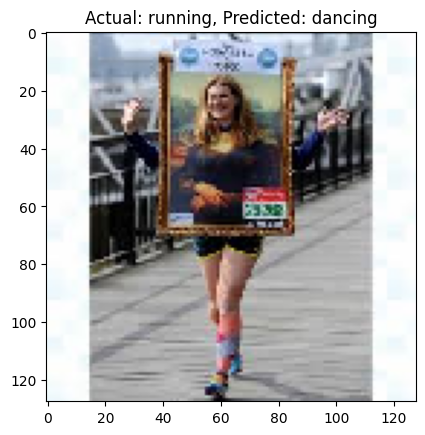

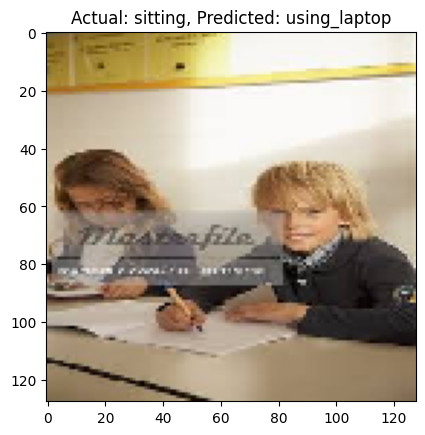

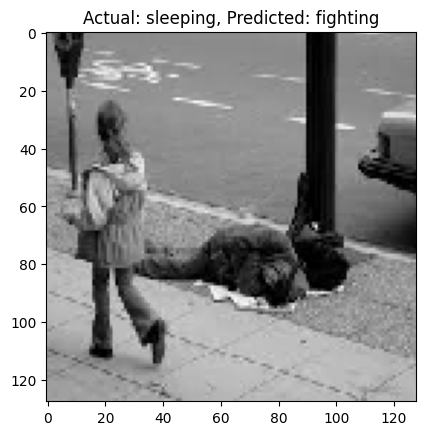

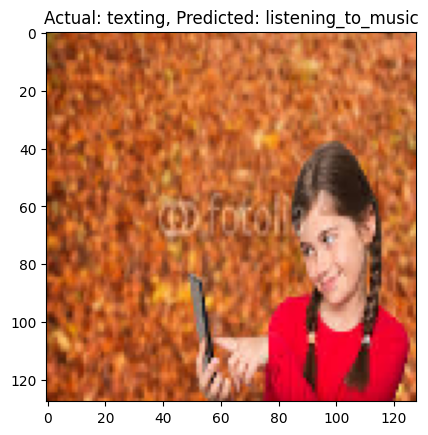

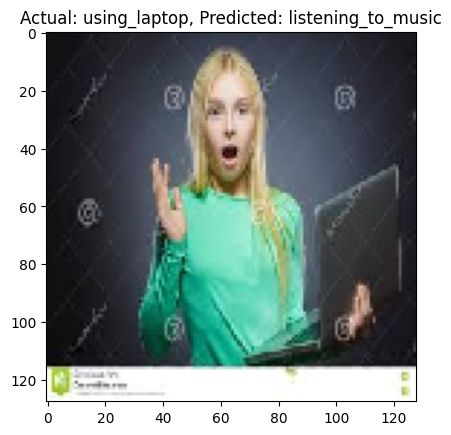

In [28]:
misclassified_samples = {}
for idx, (pred, true) in enumerate(zip(predicted_classes, true_classes)):
    if pred != true and true not in misclassified_samples:
        misclassified_samples[true] = idx
        if len(misclassified_samples) == len(test_generator.class_indices):
            break
index_to_class = {v: k for k, v in test_generator.class_indices.items()}

# Display misclassified images
for true, index in misclassified_samples.items():
    img_path = test_generator.filepaths[index]
    img = load_img(img_path, target_size=(128, 128))
    plt.figure()
    plt.imshow(img)
    plt.title(f"Actual: {index_to_class[true]}, Predicted: {index_to_class[predicted_classes[index]]}")
    plt.show()